**Predmet: Principi prezentacije i prepoznavanja oblika**

**Predmetni profesor: Marko Arsenović**

**Student: Nikola Đaković**

**Broj Indeksa: IT 24/2021**

# **Detekcija objekata pomoću modela YOLOv8s (Detekcija brodova)**

# **Sadržaj**



*   Uvod
*   YOLO algoritam
*   Preuzimanje početnog seta podataka i njegova priprema
*   Treniranje modela
*   Testiranje modela nad validacionim setom
*   Testiranje modela nad setom za testiranje
*   Zaključak
*   Reference


# Uvod


Cilj ovog projekta jeste da se trenira model da može da detektuje brodove na osnovu zadatog seta podataka i proizvoljnog izbora algoritma. Algoritam koji sam izabrao jeste YOLO algoritam.
Pre nego što objasnimo šta je YOLO algoritam, prvo ću da objasnim dataset koji sam koristio za treniranje modela.
Naziv seta podatak jeste „Ships_Detection“ i on se sastoji oh sledećih direktorijuma i fajlova:



*   *train_v2* - folder koji sadrži slike koje će se koristiti za trening modela (on sadrži 44 533 slike)
*   *test_v2* - folder koji sadrži slike koje će se koristiti za testiranje modela (on sadrži 6872 slike)

*  *train_ship_segmentations_v2.csv* -  Ovaj fajl povezuje slike sa informacijama o segmentaciji brodova i on se sastoji od kolona „ImageId“ (Jedinstveni identifikator koji zapravo predstavlja naziv slike iz gore navedenih foldera) i „EncodedPixels“ (Sadrži informacije o lokacijama brodova na slikama, izražena u formatu RLE)

Važno je napomenuti da sve slike u *train_v2* i *test_v2* folderima sadrže slike tipa .*jpg* i da su dimenzija 768 x 768.


*sample_submission_v2*.csv fajl nije uzet u obzir prilikom treniranja jer predstavlja jedan način kako možemo da pokažemo predikcije detekcija brodova na slikama koje se nalaze u „test_v2“  folderu.






# YOLO algoritam

YOLO (eng. *You Only Look Once*) je napredni algoritam za detekciju objekata u realnom vremenu.

Dok algoritmi poput Faster RCNN rade tako što detektuju moguće regione od interesa koristeći Region Proposal Network, a zatim vrše prepoznavanje tih regiona odvojeno, YOLO sva svoja predviđanja vrši uz pomoć jednog potpuno povezanog sloja

YOLO algoritam uzima sliku kao ulaz, a zatim koristi jednostavnu duboku konvolucionu neuronsku mrežu za detekciju objekata na slici.

YOLO deli ulaznu sliku na mrežu S × S. Ako centar objekta padne u ćeliju mreže, ta ćelija mreže je odgovorna za detekciju tog objekta. Svaka ćelija mreže predviđa granične okvire i ocene pouzdanosti za te okvire. Ovi rezultati pouzdanosti nam govore koliko je model siguran da okvir sadrži objekat i koliko tačno smatra da je predviđeni okvir tačan.

YOLO predviđa više ograničavajućih okvira po ćeliji mreže. Tokom obuke, želimo da samo jedan prediktor ograničavajućeg okvira bude odgovoran za svaki objekat. YOLO dodeljuje jedan prediktor da bude „odgovoran“ za predviđanje objekta na osnovu toga koje predviđanje ima najveći trenutni IoU sa osnovnom istinitom vrednosti.

IoU će biti kasnije objašnjen (u delu "Testiranje modela nad validacionim setom")

# Preuzimanje početnog seta podataka i njegova priprema



U ovom delu su prvo uvezene sve potrebne biblioteke za izradu projekta. Nakon toga sledi provera da li je GPU dostupan, radi budućeg bržeg izvršavanja treniranja modela.

Kad je to provereno onda se preuzima dataset koji se naziva Ships_Detection i on se otpakuje. Po završetku raspakivanja, definišem putanje do foldera ("train_v2" i "test_v2") i csv fajlova ("train_ship_segmentations_v2.csv" i "sample_submission_v2.csv") i testiram da li je sve pravilno uvezeno.

Sledeći korak jeste sređivanje preuzetih podataka. Prvo učitavamo fajl "train_segmentations_v2.csv" u DataFrame i u njemu se može videti da sadrži veliki broj redova sa 2 kolone ("ImageId" i "EncodedPixels"). Pravimo novi DataFrame gde na osnovu prethodnog DataFrame-a grupišemo po "ImageId" i menjamo NaN vrednosti sa praznim listama.

Pored toga, kreira se folder "ship_yolo_dataset2" koji će sadržati direktorijume "images" i "labels". U direktorijumu "images" će se nalaziti slike za trening i za validaciju ("train" i "val") koji će iz početnog trening seta biti podeljene (80% u "train", 20% u "val"). U direktorijumu "labels" će se takođe nalaziti folderi pod imenom "train" i "val" i one će sadržati tekstualne fajlove. Unutar tih tekstualnih fajlova će se nalaziti normalizovane koordinate, širina i visina za granične okvire.

I na kraju prvog dela, ubacujem slike i labele u svoje očekivane direktorijume unutar foldera "ship_yolo_dataset2".



In [ ]:
# Prvo importujem sve potrebne biblioteke

import shutil
import os
from google.colab import files
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm
!pip install -q gdown
import gdown
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Ovo služi samo da bi video da li je gpu dostupan (da li se on koristi kad je runtime konektovan na T4 GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Uređaj: {device}")

Uređaj: cuda:0


In [ ]:
# Originalni link je https://drive.google.com/file/d/1jUGqVJdECo40YKu-lDy7HPmAEj5RiFV_/view?usp=sharing
# Ovamo dole je izdvojen samo ID koji je potreban
file_id = "1jUGqVJdECo40YKu-lDy7HPmAEj5RiFV_"
output_file = "dataset.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1jUGqVJdECo40YKu-lDy7HPmAEj5RiFV_
From (redirected): https://drive.google.com/uc?id=1jUGqVJdECo40YKu-lDy7HPmAEj5RiFV_&confirm=t&uuid=84224d57-a5b1-40f6-a8eb-77c1e02be8b1
To: /content/dataset.zip
100%|██████████| 7.61G/7.61G [01:38<00:00, 77.6MB/s]


'dataset.zip'

In [ ]:
# Prvo proveravam kakav je tip fajla dataset.zip (Ovu sam komandu ubacio jer sam imao problema kad sam koristio drugu komandu za raspakovanje zip fajla)
# Ranije sam probao sa zipfile modulom da raspakujem fajl ali to nije radilo pa sam na kraju uspeo sa unrar
!file dataset.zip
!unrar x dataset.zip ships_detection/
os.listdir('ships_detection/Ships_Detection')

Streaming output truncated to the last 5000 lines.
Extracting  ships_detection/Ships_Detection/train_v2/4d7270b04.jpg        90%  OK 
Extracting  ships_detection/Ships_Detection/train_v2/4d728c210.jpg        90%  OK 
Extracting  ships_detection/Ships_Detection/train_v2/4d72de4ef.jpg        90%  OK 
Extracting  ships_detection/Ships_Detection/train_v2/4d73392e0.jpg        90%  OK 
Extracting  ships_detection/Ships_Detection/train_v2/4d7355d97.jpg        90%  OK 
Extracting  ships_detection/Ships_Detection/train_v2/4d73d8657.jpg        90%  OK 
Extracting  ships_detection/Ships_Detection/train_v2/4d7419466.jpg        90%  OK 
Extracting  ships_detection/Ships_Detection/train_v2/4d7426bc1.jpg        90%  OK 
Extracting  ships_detection/Ships_Detection/train_v2/4d744805c.jpg        90%  OK 
Extracting  ships_detection/Ships_Detection/train_v2/4d744ed88.jpg        90%  OK 
Extracting  ships_detection/S

['train_v2',
 'test_v2',
 'train_ship_segmentations_v2.csv',
 'sample_submission_v2.csv']

In [ ]:
# Ovo je putanja do Ships_Detection foldera gde se nalazi raspakovan sadržaj
base_dir = 'ships_detection/Ships_Detection'

# Putanja do train_ship_segmentations_v2.csv fajla i sample_submission_v2.csv fajla
train_segmentations_path = os.path.join(base_dir, 'train_ship_segmentations_v2.csv')
sample_submission_path = os.path.join(base_dir, 'sample_submission_v2.csv')


print(f"\nPutanja do train_ship_segmentations_v2.csv: {train_segmentations_path}")
print(f"Putanja do sample_submission_v2.csv: {sample_submission_path}")


Putanja do train_ship_segmentations_v2.csv: ships_detection/Ships_Detection/train_ship_segmentations_v2.csv
Putanja do sample_submission_v2.csv: ships_detection/Ships_Detection/sample_submission_v2.csv


In [ ]:
# Čitanje train_ship_segmentations_v2.csv fajla i ispisivanje njegovih prvih 15 redova i ispisivanje njegovog ukupnog broja redova i kolona
train_df = pd.read_csv(train_segmentations_path)
print(train_df.head(15))
print()
print(train_df.shape)

          ImageId                                      EncodedPixels
0   00003e153.jpg                                                NaN
1   0001124c7.jpg                                                NaN
2   000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3   000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4   000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5   000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6   000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7   000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8   0001b1832.jpg                                                NaN
9   00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...
10  00021ddc3.jpg  101361 1 102128 3 102896 4 103663 6 104430 9 1...
11  00021ddc3.jpg  74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
12  00021ddc3.jpg  74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
13  00021ddc3.jpg  150423 2 151190

In [ ]:
# Isto kao i gore, samo za sample_submission_v2.csv fajl
sample_df = pd.read_csv(sample_submission_path)
print(sample_df.head(15))
print()
print(sample_df.shape)

          ImageId EncodedPixels
0   00002bd58.jpg           1 2
1   00015efb6.jpg           1 2
2   00023d5fc.jpg           1 2
3   000367c13.jpg           1 2
4   0008ca6e9.jpg           1 2
5   000a4635f.jpg           1 2
6   000bd9dbf.jpg           1 2
7   000f7d875.jpg           1 2
8   0010551d9.jpg           1 2
9   001839c6f.jpg           1 2
10  002a943bf.jpg           1 2
11  00313b166.jpg           1 2
12  00327b02d.jpg           1 2
13  0035268d9.jpg           1 2
14  003b58a76.jpg           1 2

(15606, 2)


In [ ]:
from genericpath import isdir

# Sledeće dve promenljive predstavljaju samo putanje do folder train_v2 i test_v2
train_images_dir = os.path.join(base_dir, 'train_v2')
test_images_dir = os.path.join(base_dir,'test_v2')


# Provera da li se putanjom dolazi do foldera (proverava da li je train_v2 direktorijum)
# Nakon provere ispisuje se broj fajlova (u ovom slučaju slika) i imena prvih 5 fajlova
# unutar train_v2 foldera
if os.path.isdir(train_images_dir):
  train_image_files = os.listdir(train_images_dir)
  print(f"\nBroj fajlova u '{train_images_dir}': {len(train_image_files)}")
  print(f"Prvih 5 train image fajlova: {train_image_files[:5]}")

# Isto se radi i ya test_v2 folder
if os.path.isdir(test_images_dir):
  test_image_files = os.listdir(test_images_dir)
  print(f"\nBroj fajlova u '{test_images_dir}': {len(test_image_files)}")
  print(f"Prvih 5 test image fajlova: {test_image_files[:5]}")


Broj fajlova u 'ships_detection/Ships_Detection/train_v2': 44533
Prvih 5 train image fajlova: ['14396084a.jpg', '4feefff7f.jpg', '15fa3032b.jpg', '47f604bcf.jpg', '519d8fc6e.jpg']

Broj fajlova u 'ships_detection/Ships_Detection/test_v2': 6872
Prvih 5 test image fajlova: ['9adff609a.jpg', '6d744b4a1.jpg', '6c8983b68.jpg', '2ce1822e9.jpg', '46fed5565.jpg']


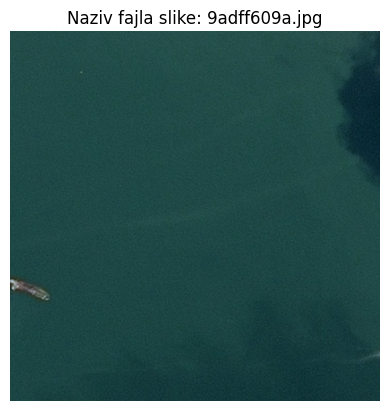

In [ ]:
#  Provera da li se slike dobro očitavaju sa foldera train_v2
if train_image_files:
  first_train_image_path = os.path.join(train_images_dir, train_image_files[0])
  img = Image.open(first_train_image_path)
  plt.imshow(img)
  plt.title(f"Naziv fajla slike: {test_image_files[0]}")
  plt.axis('off')
  plt.show()

In [ ]:
# Ovo su pomoćne metode

def rle_decode(mask_rle, shape=(768, 768)):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def masks_as_image(in_mask_list, img_shape=(768, 768)):

    # Dekodiranje liste RLE maski u jednu binarnu sliku.
    all_masks = np.zeros(img_shape, dtype=np.uint8)
    for mask_rle in in_mask_list:
        if isinstance(mask_rle, str):
            all_masks += rle_decode(mask_rle, img_shape)
    return np.clip(all_masks, 0, 1)

In [ ]:
# Učitavanje fajla train_ship_segmentations_v2.csv
segmentations_df = pd.read_csv(train_segmentations_path)
print(f"Oblik od Dataframe-a za segmentations_df: {segmentations_df.shape}")

# Grupisanje maski po ID-ju od slike
grouped_masks = segmentations_df.groupby('ImageId')['EncodedPixels'].apply(list).reset_index()

# Menjanje NaN vrednosti sa praznom listom
grouped_masks['EncodedPixels'] = grouped_masks['EncodedPixels'].apply(lambda x: [] if x == [np.nan] else x)
grouped_masks.dropna(subset=['EncodedPixels'], inplace=True)
print(f"Oblik od Dataframe-a za grouped_masks: {grouped_masks.shape}")
print()
print("grouped_masks (prvih 5 redova):")
print(grouped_masks.head(5))

Oblik od Dataframe-a za segmentations_df: (231723, 2)
Oblik od Dataframe-a za grouped_masks: (192556, 2)

grouped_masks (prvih 5 redova):
         ImageId                                      EncodedPixels
0  00003e153.jpg                                                 []
1  0001124c7.jpg                                                 []
2  000155de5.jpg  [264661 17 265429 33 266197 33 266965 33 26773...
3  000194a2d.jpg  [360486 1 361252 4 362019 5 362785 8 363552 10...
4  0001b1832.jpg                                                 []


In [ ]:
# U ovom delu sam kreirao foldere u koji ćemo na osnovu početnog train_v2 foldera podeliti na trening podatke i validacione podatke
# Zajedno sa njima, takođe su napravljeni folderi za labele
yolo_base_dir = 'ship_yolo_dataset2' # output folder
yolo_images_dir = os.path.join(yolo_base_dir, 'images')
yolo_labels_dir = os.path.join(yolo_base_dir, 'labels')

os.makedirs(os.path.join(yolo_images_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(yolo_images_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(yolo_labels_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(yolo_labels_dir, 'val'), exist_ok=True)

print(f"\nKreiran dataset za YOLO u folderu : {yolo_base_dir}")

# Takođe sam postavio dimenzije od slika
IMAGE_HEIGHT, IMAGE_WIDTH = 768, 768


Kreiran dataset za YOLO u folderu : ship_yolo_dataset2


In [ ]:
all_image_ids = grouped_masks['ImageId'].unique()
train_ids, val_ids = train_test_split(all_image_ids, test_size=0.2, random_state=42)

print(f"\nUkupan broj jedinstvenih ID-jeva slika: {len(all_image_ids)}")
print(f"Trening ID-jeva slika: {len(train_ids)}")
print(f"Validacioni ID-jevi slika: {len(val_ids)}")


train_ids_set = set(train_ids)
val_ids_set = set(val_ids)

# Prolaženje kroz sve grupisane slike
for index, row in tqdm(grouped_masks.iterrows(), total=len(grouped_masks), desc="Processing images"):
    image_id = row['ImageId']
    rle_masks = row['EncodedPixels']


    # Određivanje da li je slika za trening set podataka ili validacioni set podataka
    if image_id in train_ids_set:
        subset_images_dir = os.path.join(yolo_images_dir, 'train')
        subset_labels_dir = os.path.join(yolo_labels_dir, 'train')
    elif image_id in val_ids_set:
        subset_images_dir = os.path.join(yolo_images_dir, 'val')
        subset_labels_dir = os.path.join(yolo_labels_dir, 'val')
    else:
        print(f"Slika {image_id} nije nađena u trening niti u validacion setu. Preskočeno.")
        continue

    # Putanja do izvorne slike
    source_image_path = os.path.join(train_images_dir, image_id)
    if not os.path.exists(source_image_path):
        print(f"Slika uopšte nije pronađena: {source_image_path}. Preskočeno.")
        continue

    yolo_annotations = []

    if rle_masks:
        combined_mask = masks_as_image(rle_masks, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Pronalaženje kontura
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            # Dobijanje koordinata graničnog okvira (bounding box) za svaku konturu
            x, y, w, h = cv2.boundingRect(contour)

            # Convert to YOLO format (normalized center_x, center_y, width, height)
            x_center = (x + w / 2) / IMAGE_WIDTH
            y_center = (y + h / 2) / IMAGE_HEIGHT
            norm_width = w / IMAGE_WIDTH
            norm_height = h / IMAGE_HEIGHT

            yolo_annotations.append(f"0 {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")

    # Ovamo sam sačuvao YOLO anotacije u tekstualne fajlove
    label_filename = os.path.join(subset_labels_dir, image_id.replace('.jpg', '.txt'))
    with open(label_filename, 'w') as f:
        f.write("\n".join(yolo_annotations))

    # Kopiranje slike do YOLO dataset foldera
    !cp "{source_image_path}" "{subset_images_dir}/"

print("\n Sređivanje podataka je gotovo!")


Ukupan broj jedinstvenih ID-jeva slika: 192556
Trening ID-jeva slika: 154044
Validacioni ID-jevi slika: 38512


Processing images:   0%|          | 0/192556 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Slika uopšte nije pronađena: ships_detection/Ships_Detection/train_v2/f9780bfaf.jpg. Preskočeno.
Slika uopšte nije pronađena: ships_detection/Ships_Detection/train_v2/f9782bdfe.jpg. Preskočeno.
Slika uopšte nije pronađena: ships_detection/Ships_Detection/train_v2/f9785ca49.jpg. Preskočeno.
Slika uopšte nije pronađena: ships_detection/Ships_Detection/train_v2/f9785e462.jpg. Preskočeno.
Slika uopšte nije pronađena: ships_detection/Ships_Detection/train_v2/f97a719d5.jpg. Preskočeno.
Slika uopšte nije pronađena: ships_detection/Ships_Detection/train_v2/f97afa376.jpg. Preskočeno.
Slika uopšte nije pronađena: ships_detection/Ships_Detection/train_v2/f97b85e3e.jpg. Preskočeno.
Slika uopšte nije pronađena: ships_detection/Ships_Detection/train_v2/f97bd0b11.jpg. Preskočeno.
Slika uopšte nije pronađena: ships_detection/Ships_Detection/train_v2/f97bd6b80.jpg. Preskočeno.
Slika uopšte nije pronađena: ships_detection/Ships_Detection/train_v2/f97bfb

In [ ]:
print("Predstavljanje slike sa označenim brodovima")

# Ovamo sam uzeo train_ids[10] jer ona zapravo sadrži brod na slici, pa se granični okviri iscrtaju nakon izvršavanja koda
# Slike pre ove nisu sadržale brodove, pa se granični okviri nisu ni crtali
sample_image_id = train_ids[10]
sample_image_path_in_yolo_dir = os.path.join(yolo_images_dir, 'train', sample_image_id)
sample_label_path = os.path.join(yolo_labels_dir, 'train', sample_image_id.replace('.jpg', '.txt'))

if os.path.exists(sample_image_path_in_yolo_dir) and os.path.exists(sample_label_path):
    img = cv2.imread(sample_image_path_in_yolo_dir)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with open(sample_label_path, 'r') as f:
        lines = f.readlines()

    if lines:
        for line in lines:
            parts = line.strip().split()

            x_center, y_center, norm_width, norm_height = map(float, parts[1:])

            # Konvertovanje normalizovanih YOLO koordinata nazad u pixel koordinate
            x1 = int((x_center - norm_width / 2) * IMAGE_WIDTH)
            y1 = int((y_center - norm_height / 2) * IMAGE_HEIGHT)
            x2 = int((x_center + norm_width / 2) * IMAGE_WIDTH)
            y2 = int((y_center + norm_height / 2) * IMAGE_HEIGHT)

            # Crtanje pravougaonika
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2) # Red color, 2px thickness
            cv2.putText(img_rgb, 'ship', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title(f"Slika: {sample_image_id} sa graničnim okvirom")
    plt.axis('off')
    plt.show()
else:
    print(f"Slika ili labela nije pronađena : {sample_image_id}")


# Treniranje modela

Pre početka treniranja modela nad našim setom podataka (u ovom slučaju, nad sređenim setu podataka unutar foldera "ship_yolo_dataset2") prvo moramo da instaliramo potrebnu zavisnost ultralytics (On je u dokumentaciji detaljnije objašnjen).

Nakon što smo instalirali zavisnost, pravimo YAML fajl koji ćemo proslediti modelu. Unutar YAML fajla će se samo nalaziti putanje za trening i validacione podatke, broj klasa i ime od tih klasa (U slučaju ovog projekta, samo "ship").

Kad je YAML fajl kreiran, preuzimamo postojeći model "yolov8s.pt" pomoću ultralytics-a. Posle toga, sledi trening modela. Metodi koja se se poziva za trening modela je prosleđena putanja do YAML fajla, broj epoha, veličina ulaznih slika, broj slika koji će se paralelno obrađivati, i ime fajla koji će se generisati (on predstavlja rezultate treninga). Razlog malog broja epoha i broja slika koji će se paralelno obrađivati je naveden dole, ispod poziva metode za treniranje modela.    



In [ ]:
# Instalacija ultralitycs-a, on nam je potreban za preuzimanje yolov8s modela
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.5 MB/s eta 0:00:00


In [ ]:
# Pravljenje YAML fajla koje ću koristiti za treniranje modela (samo za čuvanje putanja koji će se koristiti, broj klasa i imena tih klasa, mada u ovom slučaju imamo samu jednu klasu)

data_yaml_path = 'shipsYolo.yaml'

data_yaml_content = f"""
# Dataset YAML za detekciju brodova
train: {os.path.abspath(yolo_images_dir)}/train
val: {os.path.abspath(yolo_images_dir)}/val

# Broj klasa
nc: 1

# Ime klasa
names: ['ship']
"""

with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content)

# Ispisivanje sadržaja YAML fajla
!cat {data_yaml_path}


# Dataset YAML za detekciju brodova
train: /content/ship_yolo_dataset2/images/train
val: /content/ship_yolo_dataset2/images/val

# Broj klasa
nc: 1

# Ime klasa
names: ['ship']


In [ ]:
from ultralytics import YOLO

# Učitavanje postojećeg modela
model = YOLO('yolov8s.pt')

print(f"Model je učitan!")

Model je učitan!


In [ ]:
# Pokrećem metodu model.train() pomoću koje model treniramo nad zadatim datasetom

# Bitno je da napomenuti parametre, a oni su:
# data - Putanja do YAML fajla
# epochs - Broj trening epoha
# imgsz - Veličina ulaznih slika
# batch - Broj slika koji će paralelno da se obrađuju
# name - Ime fajla koji će se generisati i koji predstavlja rezultate treninga
results = model.train(
    data=data_yaml_path,
    epochs=5,
    imgsz=768,
    batch=16,
    name='shipdetectionmodel(Nikola Djakovic)verzija32'
)

# Bitno mi je samo da napomenem da sam stavio da mi je broj epoha 5 i batch size 16 (umesto na primer 32 ili 64) jer mi je predugo trajalo
# i često kad sam pokretao nisam imao dovoljno vremena pa mi vreme za runtime se istroši i onda moram sve ispočetka.
# Batch size sam stavio na 16, jer kad sam stavio na 32, uvek mi je krešovao runtime, probao sam isto staviti 20, ali sam imao isti problem

print("\n--- Treniranje modela je završeno! ---")


Ultralytics 8.3.172 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=shipsYolo.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=shipdetectionmodel(Nikola Djakovic)verzija32, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

train: Scanning /content/ship_yolo_dataset2/labels/train... 35636 images, 27703 backgrounds, 0 corrupt: 100%|██████████| 35636/35636 [01:08<00:00, 523.14it/s]


train: New cache created: /content/ship_yolo_dataset2/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 26.3±13.0 MB/s, size: 139.1 KB)


val: Scanning /content/ship_yolo_dataset2/labels/val... 8897 images, 6948 backgrounds, 0 corrupt: 100%|██████████| 8897/8897 [00:18<00:00, 486.22it/s]


val: New cache created: /content/ship_yolo_dataset2/labels/val.cache
Plotting labels to runs/detect/shipdetectionmodel(Nikola Djakovic)verzija32/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 768 train, 768 val
Using 2 dataloader workers
Logging results to runs/detect/shipdetectionmodel(Nikola Djakovic)verzija32
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.96G      1.744      3.346      1.323          1        768: 100%|██████████| 2228/2228 [17:40<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 279/279 [01:45<00:00,  2.65it/s]


                   all       8897       3350      0.578      0.387      0.424      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      6.07G      1.761      1.787      1.347          0        768: 100%|██████████| 2228/2228 [18:19<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 279/279 [01:54<00:00,  2.43it/s]


                   all       8897       3350      0.619      0.471      0.525      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      6.12G      1.657      1.555       1.28          5        768: 100%|██████████| 2228/2228 [17:13<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 279/279 [01:41<00:00,  2.74it/s]


                   all       8897       3350      0.715      0.453      0.546      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      6.15G      1.549      1.396      1.221          3        768: 100%|██████████| 2228/2228 [16:52<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 279/279 [01:42<00:00,  2.71it/s]


                   all       8897       3350      0.756      0.527      0.641      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      6.18G      1.386      1.157      1.138          2        768: 100%|██████████| 2228/2228 [16:45<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 279/279 [01:41<00:00,  2.74it/s]


                   all       8897       3350      0.752      0.607      0.705      0.447

5 epochs completed in 1.595 hours.
Optimizer stripped from runs/detect/shipdetectionmodel(Nikola Djakovic)verzija32/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/shipdetectionmodel(Nikola Djakovic)verzija32/weights/best.pt, 22.5MB

Validating runs/detect/shipdetectionmodel(Nikola Djakovic)verzija32/weights/best.pt...
Ultralytics 8.3.172 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 279/279 [01:38<00:00,  2.85it/s]


                   all       8897       3350      0.751      0.608      0.705      0.447
Speed: 0.4ms preprocess, 6.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/shipdetectionmodel(Nikola Djakovic)verzija32

--- Treniranje modela je završeno! ---


# Testiranje modela nad validacionim setom

U ovom delu model je testiran nad validacionim setom podataka i ispisane su metrike poput preciznost modela, odziv modela i metrike prosečne preciznosti.

Metrike prosečne preciznosti koje su ispisane su:


*   mAP50 - prosečna preciznost koja je izračunata sa IoU (Intersection over Union) prag od 0.5
*   mAP75 - prosečna preciznost izračunata sa strožim IOU pragom 0.75
*   mAp50-95 - Prosek mAP vrednosti na različitim IoU pragovima, od 0.5 do 0.95, sa korakom od 0.05

Bitno je samo da napomenem da IoU predstavlja meru preklapanja između predviđenog i stvarnog graničnog okvira (bounding box). Ako je preklapanje veće od određenog praga (0.5) onda možemo da kažemo da je detekcija tačna.

Na kraju sam zakomentarisao kod, koji kad se pokrene preuzeće folder u kojem se nalaze rezultati treniranja modela, a koji sad takođe sadrži i rezultate testiranja modela nad validacionim setom podataka



In [ ]:
# Ovom metodom testiram model nad validacionim setom podataka

metrics = model.val()

# Ispisivanje bitnih metrika
print(f"\nMetrike validacije:")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP75: {metrics.box.map75:.4f}")
print(f"Precision: {metrics.box.p}")
print(f"Recall: {metrics.box.r}")

print("\n Testiranje modela nad validacionim setom podataka je gotov!")

Ultralytics 8.3.172 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1892.5±504.4 MB/s, size: 128.7 KB)


val: Scanning /content/ship_yolo_dataset2/labels/val.cache... 8897 images, 6948 backgrounds, 0 corrupt: 100%|██████████| 8897/8897 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 557/557 [02:11<00:00,  4.22it/s]


                   all       8897       3350      0.754       0.61      0.705      0.446
Speed: 0.4ms preprocess, 12.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/shipdetectionmodel(Nikola Djakovic)verzija322

Metrike validacije:
mAP50-95: 0.4460
mAP50: 0.7051
mAP75: 0.4894
Precision: [    0.75404]
Recall: [    0.60955]

 Testiranje modela nad validacionim setom podataka je gotov!


In [ ]:
# Prikazivanje generisanog results.csv fajla koje je nastao kao rezultat treninga modela


results_table = pd.read_csv('runs/detect/shipdetectionmodel(Nikola Djakovic)verzija32/results.csv')

results_table

In [ ]:
# Prikazivanje matrice konfuzije (ili zbunjenosti, nisam siguran kako se tačno prevodi)

# Ovo sam bio zaboravio dodati , pa sad dodajem, zato neće biti prikazano kao da je pokrenuto ranije
confusion_matrix = mpimg.imread('runs/detect/shipdetectionmodel(Nikola Djakovic)verzija32/confusion_matrix.png')

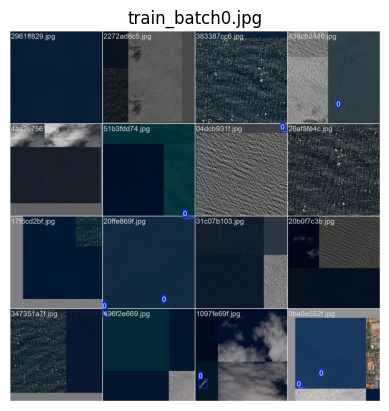

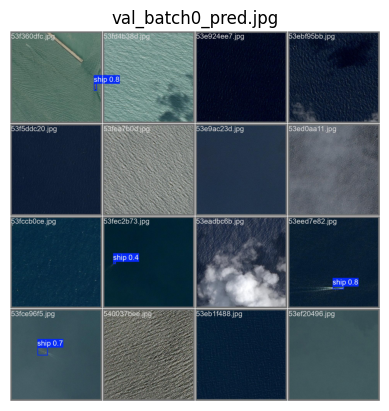

In [ ]:
# Putanja do foldera sa rezultatima
results_dir = 'runs/detect/shipdetectionmodel(Nikola Djakovic)verzija32'

# Ovamo prikazujemo sliku train_batch0.jpg koja je generisana putem model.train() metode
try:
    img = mpimg.imread(f'{results_dir}/train_batch0.jpg')
    plt.imshow(img)
    plt.title('train_batch0.jpg')
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Slika 'train_batch0.jpg' nije pronađena u {results_dir}")

# Isto kao i gore, samo za sliku val_batch0_pred.jpg
try:
    img = mpimg.imread(f'{results_dir}/val_batch0_pred.jpg')
    plt.imshow(img)
    plt.title('val_batch0_pred.jpg')
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Slika 'val_batch0_pred.jpg' nije pronađena u {results_dir}")

In [ ]:
#Izbrišite komentare ako hoćete da preuzmete folder u kome se nalaze generisani rezultati
#folder_path_for_result_folder = 'runs/detect/shipdetectionmodel(Nikola Djakovic)verzija32'

#new_zip_file_name = 'shipdetectionmodel(Nikola Djakovic)_verzija3.zip'
#new_zip_path = os.path.join('/content', new_zip_file_name)


# Prvi argument je ime arhive bez ekstenzije, drugi je format, a treći je putanja do foldera.
#shutil.make_archive(os.path.splitext(new_zip_path)[0], 'zip', folder_path_for_result_folder)

# Preuzimanje kreirane zip arhive
#files.download(new_zip_path)

# Testiranje modela nad setom za testiranje

U poslednjem delu ovog projekta, testirao sam model pomoću početnog seta za testiranje. Ovaj početni set za testiranje je zapravo "test_v2" folder koji je preuzet u početku i koji sadrži 6872 slike unutar njega.

Nakon testiranja modela, prikazao sam kako izgleda jedna slika iz "test_v2" foldera pre nego što je model pravio predikcije i kako ista slika izgleda nakon što je model izvršio predikcije nad tom slikom. Tu vidimo da je model uspešno prepoznao gde se nalaze brodovi, mada ima jedan brod koji je označen, ali ima manju verovatnoću u odnosu na ostale, što znači da model nije bio u potpunosti siguran da to što je označio jeste brod.

I na kraju je kod koji se može iskoristiti za preuzimanje čitavog foldera "test_predictions" koji sadrži sve predikcije (On je trenutno komentarisan).


In [ ]:
import os
from ultralytics import YOLO

# Učitavamo model sa prilagođenim težinama koje su dobijene treniranjem.
# Ime foldera odgovara parametru 'name' iz model.train()
custom_weights_path = 'runs/detect/shipdetectionmodel(Nikola Djakovic)verzija32/weights/best.pt'
model = YOLO(custom_weights_path)
print(f"Model je učitan sa prilagođenim težinama: {custom_weights_path}")

# Putanje do foldera
base_dir = 'ships_detection/Ships_Detection'
test_images_dir = os.path.join(base_dir, 'test_v2')

# Parametri
confidence_threshold = 0.1
image_size = 768
batch_size = 16

# Kreiranje liste svih putanja do slika
test_image_files = [f for f in os.listdir(test_images_dir) if f.endswith('.jpg')]
test_image_paths = [os.path.join(test_images_dir, f) for f in test_image_files]

# Folder za čuvanje rezultata
test_output_dir = 'runs/detect/test_predictions'
os.makedirs(test_output_dir, exist_ok=True)
print(f"Rezultati testiranja će biti sačuvani u folderu: {test_output_dir}")

print(f"Pokretanje predikcija na {len(test_image_paths)} test slika sa batch_size={batch_size}...")

# Deljenje liste slika u batch-eve
def chunk_list(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

image_batches = chunk_list(test_image_paths, batch_size)

# Iteriranje kroz svaki batch i pokretanje predikcije
batch_count = 0
for batch in image_batches:
    batch_count += 1
    print(f"Procesiranje batch-a {batch_count} od {len(test_image_paths)//batch_size + 1}...")

    predictions = model.predict(
        source=batch,
        save=True,
        save_txt=True,
        save_conf=True,
        exist_ok=True,
        project='runs/detect',
        name='test_predictions',
        conf=confidence_threshold,
        imgsz=image_size,
    )

print("\nTestiranje modela je gotovo.")

Streaming output truncated to the last 5000 lines.
11: 768x768 (no detections), 10.7ms
12: 768x768 (no detections), 10.7ms
13: 768x768 (no detections), 10.7ms
14: 768x768 (no detections), 10.7ms
15: 768x768 (no detections), 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 768)
Results saved to runs/detect/test_predictions
624 labels saved to runs/detect/test_predictions/labels
Procesiranje batch-a 193 od 430...

0: 768x768 (no detections), 10.7ms
1: 768x768 (no detections), 10.7ms
2: 768x768 (no detections), 10.7ms
3: 768x768 (no detections), 10.7ms
4: 768x768 (no detections), 10.7ms
5: 768x768 (no detections), 10.7ms
6: 768x768 (no detections), 10.7ms
7: 768x768 (no detections), 10.7ms
8: 768x768 2 ships, 10.7ms
9: 768x768 (no detections), 10.7ms
10: 768x768 (no detections), 10.7ms
11: 768x768 1 ship, 10.7ms
12: 768x768 (no detections), 10.7ms
13: 768x768 (no detections), 10.7ms
14: 768x768 (no detections), 10.7ms
15: 768x768 (no detec

Prikaz slike iz testnog seta podatak pre predikcije


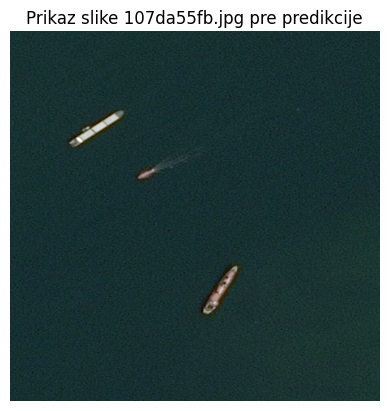

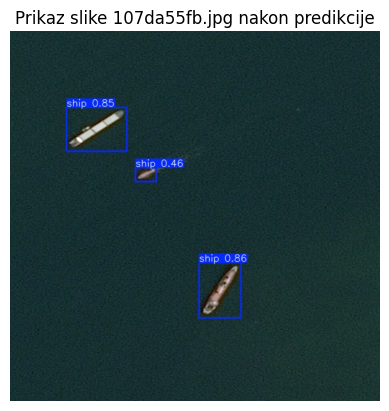

In [ ]:
# Ovo je putanja do foldera sa rezultatima predikcija
test_predictions_dir = 'runs/detect/test_predictions'

# Ovo je putanja do testnog foldera
test_picture_dir = 'ships_detection/Ships_Detection/test_v2'

print("Prikaz slike iz testnog seta podatak pre predikcije")

try:
    img = mpimg.imread(f'{test_picture_dir}/107da55fb.jpg')
    plt.imshow(img)
    plt.title('Prikaz slike 107da55fb.jpg pre predikcije')
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Slika '107da55fb.jpg' nije pronađena u {test_picture_dir}")

# Ovamo prikazujemo sliku koja ima označene granične okvire i verovatnoće koja je generisana
# nakon predviđanja
try:
    img = mpimg.imread(f'{test_predictions_dir}/107da55fb.jpg')
    plt.imshow(img)
    plt.title('Prikaz slike 107da55fb.jpg nakon predikcije')
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Slika '107da55fb.jpg' nije pronađena u {test_predictions_dir}")


In [ ]:
#Izbrišite komentare ako hoćete da preuzmete folder u kome se
# nalaze rezultati predikcija slika iz foldera test_v2
# (Zipovanje i preuzimanje foldera mi je dugo potrajalo)

#folder_path_for_predictions = 'runs/detect/test_predictions'

#new_zip_file_name_predictions = 'ship_predictions.zip'
#new_zip_path_predictions = os.path.join('/content', new_zip_file_name_predictions)


# Prvi argument je ime arhive bez ekstenzije, drugi je format, a treći je putanja do foldera.
#shutil.make_archive(os.path.splitext(new_zip_path_predictions)[0], 'zip', folder_path_for_predictions)

# Preuzimanje kreirane zip arhive
#files.download(new_zip_path_predictions)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Zaključak

Izradom ovog projekta sam stekao znanje o treniranju i testiranju modela za detekciju objekata. Kada sam malo dublje analizirao folder "test_predictions" primetio sam da ponekad neki brodovi nisu bili označeni i da postoji isto puno slučajeva da su brodovi označeni ali da im je model pridružio male verovatnoće, što znači da nije u potpunosti siguran da li se uopšte radi o brodu.

Isto je bitno napomenuti da analizom "results.csv" fajla koji je generisan nakon treninga modela može da se vidi da je 5. epoha (ujedno i poslednja) bila najbolja (preciznost je bila druga najpovoljnija od svih 5 epoha, a odziv i vrednost mAP50 je bila najbolja).

# Reference



*   Materijali iz vezbe 9
*   [How YOLO Object Detection Works](https://www.youtube.com/watch?v=svn9-xV7wjk)
*   [YOLO: Algorithm for Object Detection Explained [+Examples]](https://www.v7labs.com/blog/yolo-object-detection)
*   [YOLO Object Detection Explained](https://www.datacamp.com/blog/yolo-object-detection-explained)
*   [Ultralitycs YOLO](https://github.com/ultralytics/ultralytics)

